<a href="https://colab.research.google.com/github/Keith-Tan-IT/Keith-Tan-IT/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/9444 Project
!ls

/content/drive/MyDrive/9444 Project
 0892138cf75be9b99b80d58ffddc9b73_t.gif		   COMP9444_24T2_Project_Descriptions.pdf
'9444 Project.ipynb'				   COMP9444_Project_Marking_Criteria.pdf
 9444RNN.py					   undersampled.csv
 COMP9444_24T2_GroupProject_Report-TeamName.docx


In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
!pip install datasets


In [15]:
!pip install --upgrade pyarrow


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Training dataset size: 16000
Validation dataset size: 2000
Test dataset size: 2000
Training with optimizer=adam, lr=0.01, dropout_rate=0.2, lstm_units=8, loss=categorical_crossentropy, activation=softmax
Epoch 1/10
250/250 [==============================] - 51s 196ms/step - loss: 0.8229 - accuracy: 0.7121 - val_loss: 0.3201 - val_accuracy: 0.8895
Epoch 2/10
250/250 [==============================] - 51s 205ms/step - loss: 0.2435 - accuracy: 0.9155 - val_loss: 0.3153 - val_accuracy: 0.8955
Epoch 3/10
250/250 [==============================] - 49s 194ms/step - loss: 0.1521 - accuracy: 0.9487 - val_loss: 0.3104 - val_accuracy: 0.8920
Epoch 4/10
250/250 [==============================] - 48s 194ms/step - loss: 0.1038 - accuracy: 0.9644 - val_loss: 0.3195 - val_accuracy: 0.8985
Epoch 5/10
250/250 [==============================] - 48s 194ms/step - loss: 0.0828 - accuracy: 0.9721 - val_loss: 0.3568 - val_accuracy: 0.8915
Epoch 6/10
63/63 [==============================] - 1s 14ms/step - loss

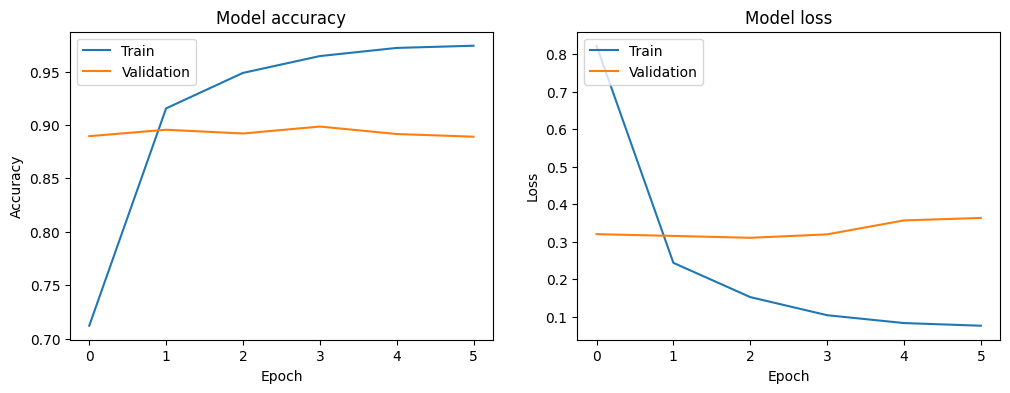

In [1]:
import pandas as pd  # Importing the pandas library for data manipulation and analysis
import numpy as np  # Importing the numpy library for numerical operations
import tensorflow as tf  # Importing TensorFlow for building and training deep learning models
from tensorflow.keras.preprocessing.text import Tokenizer  # Importing the Tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Importing pad_sequences to pad sequences to the same length
from tensorflow.keras.models import Sequential  # Importing Sequential to initialize a sequential model
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout  # Importing various layers for the model
from tensorflow.keras.callbacks import EarlyStopping  # Importing EarlyStopping to stop training when a monitored metric has stopped improving
from sklearn.preprocessing import LabelEncoder  # Importing LabelEncoder to encode target labels with value between 0 and n_classes-1
from sklearn.model_selection import train_test_split  # Importing train_test_split to split arrays or matrices into random train and test subsets
import matplotlib.pyplot as plt  # Importing matplotlib for plotting



from datasets import load_dataset

# 加载数据集
train_dataset = load_dataset("dair-ai/emotion", split="train")
valid_dataset = load_dataset("dair-ai/emotion", split="validation")
test_dataset = load_dataset("dair-ai/emotion", split="test")

# 打印数据集大小
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# 提取文本和标签
train_texts = train_dataset['text']
train_labels = train_dataset['label']
valid_texts = valid_dataset['text']
valid_labels = valid_dataset['label']
test_texts = test_dataset['text']
test_labels = test_dataset['label']

# Ensure all text entries are strings
train_texts = [str(text) for text in train_texts]
valid_texts = [str(text) for text in valid_texts]
test_texts = [str(text) for text in test_texts]

# Preprocess the data
MAX_NB_WORDS = 50000  # Maximum number of words to keep, based on word frequency
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences (number of words)
EMBEDDING_DIM = 100  # Dimension of the embedding vectors

# Tokenizing the text data
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)  # Initializing the Tokenizer with max number of words
tokenizer.fit_on_texts(train_texts)  # Fitting the tokenizer on the text data
word_index = tokenizer.word_index  # Getting the word index (dictionary mapping words to their index)

# Converting text to sequences and padding them
X_train = tokenizer.texts_to_sequences(train_texts)  # Converting text to sequences of integers
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)  # Padding sequences to ensure uniform length

X_val = tokenizer.texts_to_sequences(valid_texts)
X_val = pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(test_texts)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

# Encoding the labels
le = LabelEncoder()  # Initializing the LabelEncoder
y_train = le.fit_transform(train_labels)  # Fitting and transforming the labels to integer encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=6)  # Converting labels to categorical (one-hot encoding)

y_val = le.transform(valid_labels)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=6)

y_test = le.transform(test_labels)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=6)

# Function to build the LSTM model
def create_model(optimizer='adam', learning_rate=0.01, dropout_rate=0.2, lstm_units=8, loss='categorical_crossentropy', activation='softmax'):
    model = Sequential()  # Initializing a sequential model
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))  # Adding an embedding layer
    model.add(SpatialDropout1D(dropout_rate))  # Adding a spatial dropout layer for regularization
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))  # Adding the LSTM layer with dropout
    model.add(Dense(6, activation=activation))  # Adding a dense output layer with softmax activation

    # Choosing the optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # Adam optimizer
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)  # RMSprop optimizer
    elif optimizer == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)  # Nadam optimizer

    # Compiling the model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])  # Compiling the model with the given loss function, optimizer, and accuracy metric
    return model  # Returning the compiled model

# Specified hyperparameters
params = {
    'optimizer': 'adam',  # Optimizer
    'learning_rate': 0.01,  # Learning rate
    'dropout_rate': 0.2,  # Dropout rate
    'lstm_units': 8,  # LSTM units
    'loss': 'categorical_crossentropy',  # Loss function
    'activation': 'softmax'  # Activation function for the output layer
}

print(f"Training with optimizer={params['optimizer']}, lr={params['learning_rate']}, dropout_rate={params['dropout_rate']}, lstm_units={params['lstm_units']}, loss={params['loss']}, activation={params['activation']}")  # Printing the hyperparameters

# Creating the model with the specified hyperparameters
model = create_model(optimizer=params['optimizer'], learning_rate=params['learning_rate'], dropout_rate=params['dropout_rate'], lstm_units=params['lstm_units'], loss=params['loss'], activation=params['activation'])

# Training the model
history = model.fit(X_train, y_train,
                    epochs=10,  # Number of epochs
                    batch_size=64,  # Batch size
                    validation_data=(X_val, y_val),  # Validation data
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])  # Early stopping to prevent overfitting

# Evaluating the model
accr = model.evaluate(X_test, y_test)  # Evaluating the model on the test set
print(f"Test accuracy: {accr[1]}")  # Printing the test accuracy

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))  # Setting the figure size
plt.subplot(1, 2, 1)  # Creating the first subplot
plt.plot(history.history['accuracy'])  # Plotting training accuracy
plt.plot(history.history['val_accuracy'])  # Plotting validation accuracy
plt.title(f"Model accuracy")  # Setting the title
plt.ylabel('Accuracy')  # Setting the y-axis label
plt.xlabel('Epoch')  # Setting the x-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Adding a legend

# Plotting training & validation loss values
plt.subplot(1, 2, 2)  # Creating the second subplot
plt.plot(history.history['loss'])  # Plotting training loss
plt.plot(history.history['val_loss'])  # Plotting validation loss
plt.title(f"Model loss")  # Setting the title
plt.ylabel('Loss')  # Setting the y-axis label
plt.xlabel('Epoch')  # Setting the x-axis label
plt.legend(['Train', 'Validation'], loc='upper left')  # Adding a legend

plt.show()  # Displaying the plots
